In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import gdal, ogr
from netCDF4 import Dataset
import rasterio
import xarray as xr
import os, os.path
from shapely.geometry import Polygon, Point, LineString
from math import radians, sin, cos, asin, sqrt, atan2
import re

%matplotlib inline
directory = '../data'

eez = 5.556

# Read SST

In [72]:
#https://www1.ncdc.noaa.gov/pub/data/cmb/ersst/v5/netcdf/
#sst = xr.open_dataset(directory+"/temp/global/ersst/ersst.v5.201805.nc").to_dataframe()
#sst.reset_index(inplace=True)

#better data than above
#gathered two data points for each month (Oct - May?) to get a general feel for the temp in this growth/harvest period
filelist = os.listdir("../data/temp/global/oisst") 
df_list = [xr.open_dataset('../data/temp/global/oisst/'+file).to_dataframe() for file in filelist]
oisst = pd.concat(df_list)
oisst.reset_index(inplace=True)
oisst['analysed_sst'] -= 273.15
print(oisst.shape)
print(min(oisst.lat), max(oisst.lat),min(oisst.lon),max(oisst.lon))
oisst = oisst[(oisst.lat >32.4) & (oisst.lat <=42.3) & (oisst.lon >= -124) & (oisst.lon <=-117)]
oisst.drop(['time','mask','sea_ice_fraction','lat','lon','analysis_error','nv'],\
               axis=1, inplace=True)
oisst = oisst[np.isfinite(oisst['analysed_sst'])]
print(oisst.shape)
oisst.head()

(33177600, 10)
-89.875 89.875 -179.875 179.875
(11296, 3)


lat_bnds  lon_bnds  analysed_sst
1411648     32.50   -124.00     18.529993
1411649     32.75   -123.75     18.529993
1411650     32.50   -123.75     18.559991
1411651     32.75   -123.50     18.559991
1411652     32.50   -123.50     18.559991

In [73]:
#create mean, max, and min temps for the data
mean_temps = oisst.groupby(['lat_bnds','lon_bnds']).mean()
max_temps = oisst.groupby(['lat_bnds','lon_bnds']).max()
min_temps = oisst.groupby(['lat_bnds','lon_bnds']).min()
mean_temps.reset_index(inplace=True)
max_temps.reset_index(inplace=True)
min_temps.reset_index(inplace=True)
max_temps['max_temp'] = max_temps.analysed_sst
min_temps['min_temp'] = min_temps.analysed_sst
mean_temps['mean_temp'] = mean_temps.analysed_sst
max_temps.drop(['analysed_sst'], axis=1, inplace=True)
min_temps.drop(['analysed_sst'], axis=1, inplace=True)
mean_temps.drop(['analysed_sst'], axis=1, inplace=True)
print(mean_temps.shape)
mean_temps.head()

(410, 3)


lat_bnds  lon_bnds  mean_temp
0      32.5   -124.00  16.686864
1      32.5   -123.75  16.615615
2      32.5   -123.50  16.574993
3      32.5   -123.25  16.543119
4      32.5   -123.00  16.536871

In [74]:
#aggregate into one big df
sst = mean_temps.merge(max_temps, on=["lat_bnds","lon_bnds"], how='inner')\
                         .merge(min_temps, on=["lat_bnds","lon_bnds"], how='inner')
#create points from sst
geom = sst.apply(lambda x : Point([x['lat_bnds'],x['lon_bnds']]), axis=1)
sst.drop(['lat_bnds','lon_bnds'], axis=1, inplace=True)
sst = gpd.GeoDataFrame(sst, crs = {'init' :'epsg:4326'}, geometry=geom)

In [75]:
sst.head()
sst.to_pickle('../data/pickles/sst_ca.pkl')

In [4]:
#get values for a given point. We may want to do the kirging option instead of this.
lat = 35.863
lon = -133.72
vertices = (sst_overview.iloc[np.sqrt((sst_overview.lon_bnds-lon)**2+(sst_overview.lat_bnds-lat)**2).argsort()[:3]])
vertices.reset_index(drop=True, inplace = True)
print(vertices)
#set these to find out which row contains the closest pair along the lat/long axes.
lat_pair = None
lon_pair = None
if vertices.iloc[0].lat_bnds == vertices.iloc[1].lat_bnds:
    lat_diff = abs(vertices.iloc[0].lat_bnds - vertices.iloc[2].lat_bnds)
    lon_diff = abs(vertices.iloc[0].lon_bnds - vertices.iloc[1].lon_bnds)
    lat_pair = 1
    long_pair = 2
else:
    lat_diff = abs(vertices.iloc[0].lat_bnds - vertices.iloc[1].lat_bnds)
    lon_diff = abs(vertices.iloc[0].lon_bnds - vertices.iloc[2].lon_bnds)
    lat_pair = 2
    lon_pair = 1
print("lat_diff: {}, lon_diff: {}".format(lat_diff, lon_diff))

point_lat_diff = round(abs(vertices.iloc[0].lat_bnds - lat),2)
point_lon_diff = round(abs(vertices.iloc[0].lon_bnds - lon),2)
print("point_lat_diff: {}, point_lon_diff: {}".format(point_lat_diff, point_lon_diff))
point_lat_pct = point_lat_diff/lat_diff
point_lon_pct = point_lon_diff/lon_diff
print("point_lat_pct: {}, point_lon_pct: {}".format(point_lat_pct, point_lon_pct))

lat_temp_diff = vertices.iloc[lat_pair] - vertices.iloc[0]
lon_temp_diff = vertices.iloc[lon_pair] - vertices.iloc[0]

point_lat_temp = lat_temp_diff*point_lat_pct
point_lon_temp = lon_temp_diff*point_lon_pct
#print("poin_lat_temp: {}, point_lon_temp: {}".format(point_lat_temp, point_lon_temp))

#take into account negative temperature changes
length_fraction = (point_lat_temp + point_lon_temp)/(abs(point_lat_temp)+ abs(point_lon_temp))
point_temp = vertices.iloc[0]+length_fraction*(np.sqrt(point_lat_temp**2+point_lon_temp**2))
print(point_temp)


NameError: name 'sst_overview' is not defined

# Read Bathymetry

In [7]:
#bath = xr.open_dataset("../data/bathymetry/coastal_relief_maps/crm_vol7.nc").to_dataframe()
#bath.reset_index(inplace=True)
#print("max x: {}, min x: {}, max y :{} min y: {}".format(max(bath.x), min(bath.x), max(bath.y), min(bath.y)))
#bath.head()

max x: -117.0, min x: -128.0, max y :44.0 min y: 37.0


x          y   z
0 -128.0  37.000000 NaN
1 -128.0  37.000833 NaN
2 -128.0  37.001667 NaN
3 -128.0  37.002500 NaN
4 -128.0  37.003333 NaN

In [8]:
#bath.shape (110901601, 3) 
#commented out in favor of the ETOPO1 model with lower resolution

(110901601, 3)

In [2]:
def haversine(p1,p2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Source: https://gis.stackexchange.com/a/56589/15183
    """
    lon1 = p1[0]
    lat1 = p1[1]
    lon2 = p2[0]
    lat2 = p2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6373 * c
    return km

In [3]:
#just get the base distance for one point b/c this will be close to the the right scaling
#add half a degee in lat and lon to get the second point
def get_distance_ratio(shape):
    p1 = list(shape.representative_point().coords)[0]
    p2 = (p1[0]+0.5,p1[1]+0.5)
    d_km = haversine(p1,p2)
    #just get the base distance for one point b/c this will be close to the the right scaling for all p2s
    base_coord_d=Point(p1).distance(Point(p2))
    return d_km/base_coord_d

In [4]:
def get_distance_to_object(shape, areas):
    distance_ratio = get_distance_ratio(shape)
    distance = np.min([shape.distance(i) for i in land.geometry])*distance_ratio
    return distance

In [5]:
#import state shapefiles
states = gpd.read_file('../data/state_shapefiles/cb_2017_us_state_20m.shp')
land = states[states['STATEFP'] == '06']
# change the CRS
land = land.set_geometry('geometry').to_crs({'init':'epsg:4326'})

In [14]:
bath2 = xr.open_dataset("../../data/bathymetry/ETOPO1_Ice_g_gmt4.grd").to_dataframe()
bath2.reset_index(inplace = True)
bath2.shape

(233312401, 3)

In [15]:
bath_subset = bath2[(bath2['x'] > -124.5) & (bath2['x'] < -117) & (bath2['y'] >32.5) & (bath2['y']<42)]
bath_subset.reset_index(inplace = True, drop=True)
bath_subset.head()

x          y       z
0 -124.483333  32.500000 -4324.0
1 -124.483333  32.516667 -4331.0
2 -124.483333  32.533333 -4350.0
3 -124.483333  32.550000 -4368.0
4 -124.483333  32.566667 -4403.0

In [20]:
bath_geom = bath_subset.apply(lambda x : Point([x['x'],x['y']]), axis=1)
bath_subset = gpd.GeoDataFrame(bath_subset, geometry = bath_geom, crs = {'init' : 'epsg:4326'})
#bath_subset.drop(['x','y'], axis=1, inplace = True)
ocean_bathymetry = bath_subset[bath_subset['z']<0]
#ocean_bathymetry.plot(column='z')
print(ocean_bathymetry.shape)
ocean_bathymetry['land_distance'] = ocean_bathymetry.geometry.apply(lambda x: get_distance_to_object(x,land.geometry))
ocean_bathymetry = ocean_bathymetry[ocean_bathymetry['land_distance']<eez]
ocean_bathymetry.drop(['land_distance'], axis=1, inplace = True)
print(ocean_bathymetry.shape)
ocean_bathymetry.head()

(92615, 4)
(5371, 4)


/home/clay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


x          y     z                           geometry
1614 -124.45  40.400000 -50.0  POINT (-124.45 40.40000000000003)
1615 -124.45  40.416667 -38.0  POINT (-124.45 40.41666666666669)
1616 -124.45  40.433333 -32.0  POINT (-124.45 40.43333333333336)
1617 -124.45  40.450000 -29.0  POINT (-124.45 40.45000000000002)
1618 -124.45  40.466667 -31.0  POINT (-124.45 40.46666666666669)

In [21]:
ocean_bathymetry.to_pickle('../data/pickles/bathymetry.pkl')

# Read critical species habitats

In [9]:
#read in black abalone data
black_abalone = gpd.read_file("../data/critical/california/black_abalone/BlackAbFinalCH10272011.shp")
black_abalone['species'] = 'black abalone'
crit_species_areas = black_abalone[['species','geometry']]

leatherback = gpd.read_file("../data/critical/california/leatherback/Final_LeatherbackCH.shp")
leatherback['species'] = 'leatherback sea turtle'
crit_species_areas = crit_species_areas.append(leatherback[['species','geometry']], ignore_index=True)
#crit_species_dfs['leatherback'] = leatherback

stellar_sealions = gpd.read_file("../data/critical/california/stellar_sealions/StellerSLionCritHab_OR_CA.shp")
stellar_sealions['species'] = 'stellar sea lions'
crit_species_areas = crit_species_areas.append(stellar_sealions[['species','geometry']], ignore_index=True)
#crit_species_dfs['stellar_sealions'] = stellar_sealions

#green sturgeon had many shp files, most of which were irrelevant for our immediate purposes.
#I concatenated to relevant ones
#not relevant
#GreenSturgeonCHBypassAreas.shp (interior california)
#GreenSturgeonCHDepartmentofDefense.shp (not in ca)
#GreenSturgeonCHHeadOfTide.shp (interior)
#GreenSturgeonCHMarshAreas.shp (interior)
#GreenSturgeonCHStreams.shp (streams)
#GreenSturgeonCHTribalExclusions.shp

#relevant
#GreenSturgeonCHEstuaries.shp
#GreenSturgeonCHMarineCoastalZones.shp

green_sturgeon = gpd.read_file\
("../data/critical/california/green_sturgeon/GreenSturgeonFinalCH/GreenSturgeonCHEstuaries.shp")
green_sturgeon = green_sturgeon.append(gpd.read_file\
("../data/critical/california/green_sturgeon/GreenSturgeonFinalCH/GreenSturgeonCHMarineCoastalZones.shp"))
green_sturgeon['species'] = 'green sturgeon'
crit_species_areas = crit_species_areas.append(green_sturgeon[['species','geometry']], ignore_index=True)
crit_species_areas.to_pickle('../data/pickles/crit_species.pkl')

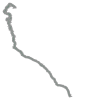

In [15]:
crit_species_areas.iloc[5].geometry

# Read Marine Protected Areas

In [13]:
def eval_geom(x):
    return eval(x)

In [14]:
mpa = pd.read_csv('../data/protected/protected_areas.csv', sep=';')
mpa['Geometry'] = mpa.Geometry.apply(lambda x: eval_geom(x))
mpa.head()

Name  \
0       Pyramid Point State Marine Conservation Area   
1  Point St. George Reef Offshore State Marine Co...   
2                Southwest Seal Rock Special Closure   
3                        Castle Rock Special Closure   
4                 False Klamath Rock Special Closure   

                                            Geometry  
0  POLYGON ((42 -124.21225, 42 -124.330233, 41.95...  
1  POLYGON ((41.866667 -124.3864833, 41.86667 -12...  
2                         POINT (41.8136 -124.35165)  
3                       POINT (41.761767 -124.24915)  
4                       POINT (41.593883 -124.11165)

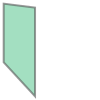

In [22]:
mpa.iloc[0]['Geometry']

In [24]:
a = Polygon([(0,0),(1,0),(0,1)])
b = Polygon([(0,0),(1,1),(1,0)])
c = Polygon([(0,0),(-1,0),(0,-1)])
d = Polygon([(0,3),(0,4),(1,3)])
e = LineString([(-1,1),(-2,2)])
f = Point(1,-1)

In [30]:
f.distance(a)

1.0

In [15]:
mpa.to_pickle('../data/pickles/mpa.pkl')

# Read Occupation Data

In [16]:
#read NES data
#Nonemp15co.txt
all_nes = pd.DataFrame()
for f in os.listdir('../../data/occupation/nonemployer_stats/csv_files'):
    nes = pd.read_csv('../../data/occupation/nonemployer_stats/csv_files/' + f)
    nes.columns = nes.columns.str.lower()
    #the files don't come with years, so I add it here
    nes['year'] = '20'+f[6:8]
    all_nes = all_nes.append(nes)

#Below are the NAICS codes for industries relevant to this analysis
#311119 Kelp meal and pellets, animal feed manufacturing

#1125 Aquaculture
#11251 Aquaculture
#112511 Finfish Farming and Fish Hatcheries
#112512 Shellfish Farming
#112519 Other Aquaculture

#1141 Fishing
#11411 Fishing
#114111 Finfish Fishing
#114112 Shellfish Fishing
#114119 Other Marine Fishing

#more clarification on a few
#112519 Other Aquaculture
#This U.S. industry comprises establishments primarily engaged in (1) farm raising of aquatic animals
#(except finfish and shellfish) and/or (2) farm raising of aquatic plants. Alligator, algae, frog, seaweed, 
#or turtle production is included in this industry.
#112519 Seaweed farming
#114119 Seaweed gathering

#relevant naics occupation codes
occupations = [311119,1125,11251,112511,112512,112519,11411,114111,114112,114119]

#Read fips codes
fips_codes = pd.read_csv('../../data/occupation/fips_county.csv')

#filter data
all_nes = all_nes.merge(fips_codes, left_on = ["st","cty"], right_on=["fips_state","fips_county"])
all_nes = all_nes[all_nes['State'] == 'CA']
all_nes = all_nes[all_nes['naics'].isin(list(map(str,occupations)))]
all_nes.drop(["st","cty","rcptot_n_f","rcptot_f","rcptot","fips_class_code"], axis=1, \
            inplace=True)
print(all_nes.shape)
all_nes.head()

(562, 8)


estab estab_f  naics  year State  fips_state  fips_county  \
557938     50     NaN  11411  2006    CA           6            1   
558406     46     NaN  11411  2007    CA           6            1   
558867     58     NaN  11411  2008    CA           6            1   
559328     55     NaN  11411  2009    CA           6            1   
559791     42     NaN  11411  2010    CA           6            1   

                  name  
557938  Alameda County  
558406  Alameda County  
558867  Alameda County  
559328  Alameda County  
559791  Alameda County

In [90]:
#only naics code 11411 is in data for CA
all_nes['naics'].unique()
all_nes.dtypes

estab           int64
estab_f        object
naics          object
year           object
State          object
fips_state      int64
fips_county     int64
name           object
dtype: object

In [4]:
#read qcew data
all_qcew = pd.DataFrame()
for f in os.listdir('../../data/occupation/qcew'):
    qcew = pd.read_csv('../../data/occupation/qcew/'+f)
    qcew = qcew[list(qcew.columns[:10])]
    qcew.drop(['own_code','qtr',], axis=1,inplace=True)
    qcew = qcew[qcew['area_fips'].str.isnumeric()]
    qcew['fips_county'] = qcew['area_fips'].str[-3:].astype(int)
    qcew['fips_state'] = qcew['area_fips'].apply(lambda x: x[:2] if len(x)>4 else x[:1]).astype(int)
    qcew = qcew.merge(fips_codes, on=["fips_state","fips_county"])
    qcew = qcew[qcew['State'] == 'CA']
    all_qcew = all_qcew.append(qcew)
all_qcew.dtypes

NameError: name 'fips_codes' is not defined

# Read in Census Population Data

In [18]:
census = pd.read_csv('../../data/population/co-est2017-alldata.csv',encoding='ISO-8859-1')
census = census[list(census.columns[3:17])]
census.drop(['CENSUS2010POP','ESTIMATESBASE2010'], inplace=True, axis=1)
#rename columns so we can merge datasets
newcolnames = ['2010','2011','2012','2013','2014','2015','2016','2017']
oldcolnames = ['POPESTIMATE'+i for i in newcolnames]
census.rename(columns = dict(zip(oldcolnames,newcolnames)), inplace=True)
census.head()

STATE  COUNTY   STNAME         CTYNAME     2010     2011     2012     2013  \
0      1       0  Alabama         Alabama  4785579  4798649  4813946  4827660   
1      1       1  Alabama  Autauga County    54750    55199    54927    54695   
2      1       3  Alabama  Baldwin County   183110   186534   190048   194736   
3      1       5  Alabama  Barbour County    27332    27351    27175    26947   
4      1       7  Alabama     Bibb County    22872    22745    22658    22503   

      2014     2015     2016     2017  
0  4840037  4850858  4860545  4874747  
1    54864    54838    55278    55504  
2   199064   202863   207509   212628  
3    26749    26264    25774    25270  
4    22533    22561    22633    22668

In [19]:
#convert the columns to rows so that we can merge datasets
census = pd.melt(census, id_vars = ['STATE','COUNTY','STNAME','CTYNAME'], var_name='year', value_name='population')
census = census.sort_values(['STATE','COUNTY'])
census.head(10)
census.dtypes

STATE          int64
COUNTY         int64
STNAME        object
CTYNAME       object
year          object
population     int64
dtype: object

In [20]:
#merge the census data with the nes data to get the percent of county workforce in a relevant occupation
all_nes = all_nes.merge(census, left_on=['fips_state','fips_county','year'],\
                        right_on=['STATE', 'COUNTY','year'], how='inner')
all_nes['pct'] = all_nes['estab']/all_nes['population']
all_nes.head()

estab estab_f  naics  year State  fips_state  fips_county            name  \
0     42     NaN  11411  2010    CA           6            1  Alameda County   
1     71     NaN  11411  2011    CA           6            1  Alameda County   
2     63     NaN  11411  2012    CA           6            1  Alameda County   
3     65     NaN  11411  2013    CA           6            1  Alameda County   
4     64     NaN  11411  2014    CA           6            1  Alameda County   

   STATE  COUNTY      STNAME         CTYNAME  population       pct  
0      6       1  California  Alameda County     1513402  0.000028  
1      6       1  California  Alameda County     1532215  0.000046  
2      6       1  California  Alameda County     1556648  0.000040  
3      6       1  California  Alameda County     1582936  0.000041  
4      6       1  California  Alameda County     1611572  0.000040

In [22]:
all_nes.to_pickle('../data/pickles/nes_occupation.pkl')

In [21]:
#merge census data to qcew data
#convert year to str for comparison
all_qcew['year'] = all_qcew.year.astype(str)
all_qcew = all_qcew.merge(census, left_on=['fips_state','fips_county','year'],\
                          right_on=['STATE','COUNTY','year'], how='inner')
all_qcew['estab_pct'] = all_qcew['annual_avg_estabs']/all_qcew['population']
all_qcew['emp_pct'] = all_qcew['annual_avg_emplvl']/all_qcew['population']
all_qcew.head()

area_fips  industry_code  agglvl_code  size_code  year disclosure_code  \
0     06007          11251           77          0  2013               N   
1     06015          11251           77          0  2013               N   
2     06015          11411           77          0  2013             NaN   
3     06019          11251           77          0  2013               N   
4     06023          11251           77          0  2013             NaN   

   annual_avg_estabs  annual_avg_emplvl  fips_county  fips_state State  \
0                  1                  0            7           6    CA   
1                  1                  0           15           6    CA   
2                 39                 81           15           6    CA   
3                  4                  0           19           6    CA   
4                  6                 19           23           6    CA   

               name fips_class_code  STATE  COUNTY      STNAME  \
0      Butte County              H1      6       7  California   
1  Del Norte County              H1      6      15  California   
2  Del Norte County              H1      6      15  California   
3     Fresno County              H1      6      19  California   
4   Humboldt County              H1      6      23  California   

            CTYNAME  population  estab_pct   emp_pct  
0      Butte County      221768   0.000005  0.000000  
1  Del Norte County       27830   0.000036  0.000000  
2  Del Norte County       27830   0.001401  0.002911  
3     Fresno County      953787   0.000004  0.000000  
4   Humboldt County      134444   0.000045  0.000141

In [23]:
all_qcew.to_pickle('../data/pickles/qcew_occupation.pkl')

# Read County shapefiles

STATEFP  COUNTYFP  COUNTYNS        AFFGEOID  GEOID           NAME LSAD  \
0        6        75  00277302  0500000US06075  06075  San Francisco   06   
1       25        25  00606939  0500000US25025  25025        Suffolk   06   
2       31         7  00835826  0500000US31007  31007         Banner   06   
3       37       181  01008591  0500000US37181  37181          Vance   06   
4       48       421  01383996  0500000US48421  48421        Sherman   06   

        ALAND     AWATER                                           geometry  
0   121485107  479107241  POLYGON ((-122.511983 37.77113, -122.465396 37...  
1   150855462  160479920  POLYGON ((-71.19115499999999 42.283059, -71.15...  
2  1932676697     397069  POLYGON ((-104.052825235239 41.69795385306401,...  
3   653705784   42187365  POLYGON ((-78.497783 36.514477, -78.4572778962...  
4  2390651189     428754  POLYGON ((-102.162463 36.500326, -102.03233901...

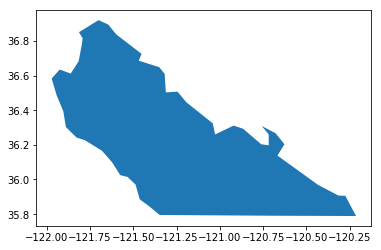

In [24]:
counties = gpd.read_file('../../data/county_shapefiles/cb_2017_us_county_20m/cb_2017_us_county_20m.shp')
counties['STATEFP'] = counties['STATEFP'].astype(int)
counties['COUNTYFP'] = counties['COUNTYFP'].astype(int)
counties[(counties['STATEFP']==6) & (counties.COUNTYFP == 53)]['geometry'].plot()
counties.head()

In [25]:
fips_codes.head()
print(fips_codes[fips_codes['State']=='CA']['fips_state'].unique())
ca_counties = counties[counties['STATEFP'] == int(fips_codes[fips_codes['State']=='CA']['fips_state'].unique())]
counties.head()

[6]


STATEFP  COUNTYFP  COUNTYNS        AFFGEOID  GEOID           NAME LSAD  \
0        6        75  00277302  0500000US06075  06075  San Francisco   06   
1       25        25  00606939  0500000US25025  25025        Suffolk   06   
2       31         7  00835826  0500000US31007  31007         Banner   06   
3       37       181  01008591  0500000US37181  37181          Vance   06   
4       48       421  01383996  0500000US48421  48421        Sherman   06   

        ALAND     AWATER                                           geometry  
0   121485107  479107241  POLYGON ((-122.511983 37.77113, -122.465396 37...  
1   150855462  160479920  POLYGON ((-71.19115499999999 42.283059, -71.15...  
2  1932676697     397069  POLYGON ((-104.052825235239 41.69795385306401,...  
3   653705784   42187365  POLYGON ((-78.497783 36.514477, -78.4572778962...  
4  2390651189     428754  POLYGON ((-102.162463 36.500326, -102.03233901...

In [27]:
ca_counties.to_pickle('../data/pickles/ca_counties.pkl')

# Read XBT bathymetry data

In [187]:
xbt = pd.read_csv('../../data/bathymetry/xbt/ca/xbts7412.csv')
xbt = xbt.append(pd.read_csv('../../data/bathymetry/xbt/ca/xbts7312.csv'))
xbt = xbt.append(pd.read_csv('../../data/bathymetry/xbt/ca/xbts7311.csv'))

In [188]:
xbt = xbt[xbt['Year'] >1996]
xbt = xbt[(xbt['Latitude'] <42.0) & (xbt['Latitude']>32.5) & (xbt['Longitude'] <-117.0) & (xbt['Longitude']>-124.5)] 

In [191]:
xbt.iloc[:1000,:26].head(1000)

ISO_country  Cruise_ID  Latitude  Longitude  Year  Month  Day   Time  \
19761          US     127670    40.372   -124.487  1998      7   17   2.57   
19775          US     127670    41.133   -124.418  1998      7   18  18.92   
19776          US     127670    41.135   -124.338  1998      7   18  19.23   
19781          US     127670    41.275   -124.398  1998      7   19   5.78   
19783          US     127670    41.633   -124.350  1998      7   19  19.37   
20516          CA      17889    41.683   -124.400  2000      3   22   5.20   
20645          US     154499    40.137   -124.365  2001      6   25  20.60   
20646          US     154499    40.137   -124.312  2001      6   25  20.87   
20648          US     154499    40.637   -124.493  2001      6   26  18.72   
20649          US     154499    40.635   -124.475  2001      6   26  18.83   
20650          US     154499    41.136   -124.338  2001      6   27  15.17   
20651          US     154499    41.135   -124.397  2001      6   27  15.45   
21469          US      28331    41.098   -124.407  2004      3    2  17.10   
21474          US      28331    41.003   -124.395  2004      3    7  17.08   
21476          US      28331    41.418   -124.385  2004      3    7  22.03   
21477          US      28331    41.505   -124.493  2004      3    7  23.02   
30218          US     127148    37.650   -123.000  1997      1   16  11.35   
30219          US     127148    37.640   -123.050  1997      1   16  11.47   
30220          US     127148    37.600   -123.170  1997      1   16  11.77   
30221          US     127148    37.510   -123.530  1997      1   16  12.67   
30222          US     127148    37.560   -123.330  1997      1   16  12.18   
30223          US     127148    37.470   -123.690  1997      1   16  13.07   
30224          US     127148    37.380   -124.000  1997      1   16  13.83   
30225          US     127148    37.280   -124.340  1997      1   16  14.65   
30246          US     127895    33.700   -120.483  1997      1   24  10.50   
30247          US     127895    33.533   -120.250  1997      1   24  14.00   
30248          US     127895    32.883   -120.217  1997      1   24  20.00   
30250          US     127172    34.458   -121.182  1997      1   28   7.08   
30253          MH     143716    37.600   -124.300  1997      1   30  11.82   
30254          CA      17795    35.100   -122.450  1997      1   30  16.27   
...           ...        ...       ...        ...   ...    ...  ...    ...   
32275          US      34361    36.723   -123.096  2001      5   17  20.90   
32276          US      34361    36.823   -122.896  2001      5   17  23.29   
32277          US      34361    36.903   -122.741  2001      5   18   1.47   
32279          US      34361    36.651   -122.321  2001      5   20   1.80   
32280          US      34361    36.578   -122.515  2001      5   20   5.98   
32281          US      34361    36.505   -122.689  2001      5   20   8.35   
32282          US      34361    36.428   -122.871  2001      5   20  12.47   
32283          US      34361    36.341   -123.050  2001      5   20  14.81   
32284          US      34361    36.252   -123.220  2001      5   20  18.14   
32285          US      34361    36.164   -123.394  2001      5   20  20.50   
32286          US      34361    36.070   -123.615  2001      5   21   0.38   
32287          US      34361    35.986   -123.752  2001      5   21   2.38   
32288          US      34361    35.911   -123.930  2001      5   21   6.07   
32289          US      34361    35.831   -124.099  2001      5   21   8.18   
32290          US      34361    35.752   -124.285  2001      5   21  12.08   
32291          US      34361    35.648   -124.443  2001      5   21  14.36   
32294          US      34361    35.819   -123.330  2001      5   22  10.99   
32295          US      34361    35.878   -123.185  2001      5   22  12.77   
32296          US      34361    35.955   -123.035  2001      5   22  14.44   
32297          US      34361

Temp_0m  Temp_5m  Temp_10m  Temp_15m  Temp_20m  Temp_25m  Temp_30m  \
0    13.40    11.52     11.47     11.53     10.87     10.69     10.53   
1    13.45    12.02     11.94     11.86     11.06     10.45      9.88   
2    13.18    12.22     11.91     10.63      9.69      9.49      9.17   
3    14.24    12.22     10.69      9.67      9.38      9.15      8.86   
4    13.48    12.12     11.31     11.09     11.00     10.73     10.68   

   Temp_35m  Temp_40m  Temp_45m           ...             Temp_8200m  \
0     10.00      9.81      9.79           ...                    NaN   
1      9.90      9.75      9.53           ...                    NaN   
2      9.07      9.06      9.08           ...                    NaN   
3      8.86      8.87      8.85           ...                    NaN   
4     10.84     10.28      9.87           ...                    NaN   

   Temp_8300m  Temp_8400m  Temp_8500m  Temp_8600m  Temp_8700m  Temp_8800m  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   Temp_8900m  Temp_9000m                 geometry  
0         NaN         NaN  POINT (-124.487 40.372)  
1         NaN         NaN  POINT (-124.418 41.133)  
2         NaN         NaN  POINT (-124.338 41.135)  
3         NaN         NaN  POINT (-124.398 41.275)  
4         NaN         NaN   POINT (-124.35 41.633)  

[5 rows x 138 columns]

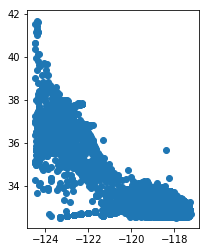

In [126]:
xbt_geom = xbt.apply(lambda x : Point([x['Longitude'],x['Latitude']]), axis=1)
xbt = gpd.GeoDataFrame(xbt, geometry = xbt_geom, crs = {'init' : 'epsg:4326'})
xbt = xbt.iloc[:,9:]
xbt.reset_index(inplace=True, drop=True)
xbt.plot()
xbt.head()

In [113]:
#xbt_sub = xbt[xbt['Latitude'] == 49.172]
#xbt_sub[xbt_sub.duplicated(['Latitude','Latitude'], keep = False)]
#xbt[xbt.duplicated(['Latitude','Latitude'], keep = False)]
#test = pd.DataFrame({'col1':[0,0,2,2,4,5,4], 'col2':[0,1,3,3,6,7,6]})
#test.head()
#test[test.duplicated(['col1','col2'], keep = False)]

In [186]:
def strip_depth_from_col(colname):
    regex = 'Temp_(\d+)m'
    depth = int(re.match(regex,colname).groups()[0])
    return depth
    
def find_seafloor(cols):
    rock_bottom = np.min(np.where(np.isnan(cols)))
    temp_seafloor = cols[rock_bottom-1]
    z_seafloor = strip_depth_from_col(cols.index[rock_bottom-1])
    return cols[rock_bottom-1], z_seafloor

xbt.iloc[:3,:-1].apply(find_seafloor, axis=1)
xbt.iloc[:1000,:20].head(1000)

Temp_0m  Temp_5m  Temp_10m  Temp_15m  Temp_20m  Temp_25m  Temp_30m  \
0     13.400   11.520    11.470    11.530    10.870    10.690    10.530   
1     13.450   12.020    11.940    11.860    11.060    10.450     9.880   
2     13.180   12.220    11.910    10.630     9.690     9.490     9.170   
3     14.240   12.220    10.690     9.670     9.380     9.150     8.860   
4     13.480   12.120    11.310    11.090    11.000    10.730    10.680   
5     11.650    9.930     9.900     9.941    10.014    10.050    10.070   
6     10.450    9.390     9.250     9.230     9.180     9.130     9.000   
7     10.790    9.190     9.030     8.910     8.900     8.830     8.710   
8     11.300   10.190    10.170    10.080     9.780     8.840     8.460   
9     10.540   10.230    10.220     9.990     8.580     8.230     8.180   
10    14.480   13.470    12.950    11.680    10.710     9.710     9.270   
11    13.680   13.250    13.250    13.250    13.160    11.970    11.400   
12    13.270   11.140    11.100    11.090    11.090    11.090    11.100   
13    12.380   11.250    11.200    11.000    10.830    10.970    10.910   
14    13.220   11.550    11.190    11.130    11.140    11.090    11.030   
15    13.370   11.530    11.350    11.220    11.160    11.110    11.050   
16    11.674   12.002    12.001    12.001    12.059    12.190    12.674   
17    11.618   12.058    12.063    12.176    12.381    12.515    12.496   
18    12.114   12.306    12.304    12.300    12.349    12.426    12.654   
19    12.660   12.841    12.860    12.835    12.816    12.786    12.764   
20    12.317   12.634    12.632    12.641    12.643    12.683    12.729   
21    12.867   12.633    12.486    12.475    12.497    12.535    12.557   
22    12.413   12.419    12.392    12.462    12.559    12.524    12.470   
23    12.460   12.565    12.564    12.558    12.626    12.771    12.757   
24    13.900   13.900    13.900    13.882    13.838    13.764    13.666   
25    13.600   13.600    13.588    13.534    13.507    13.477    13.269   
26    13.800   13.781    13.762    13.742    13.723    13.704    13.685   
27    13.860   13.750    13.740    13.710    13.640    13.470    13.170   
28    12.900   12.852    12.771    12.855    12.774    12.658    12.507   
29    13.730   13.040    13.440    13.485    13.497    13.480    13.460   
..       ...      ...       ...       ...       ...       ...       ...   
970   14.230   13.140    13.840    13.360    13.290    13.190    13.150   
971   12.980   11.940    11.870    11.810    11.860    11.810    11.750   
972   13.280   11.430    11.470    11.460    11.460    11.440    11.380   
973   14.410   13.470    12.650    12.420    12.250    12.120    12.010   
974   13.880   12.700    12.150    12.050    12.000    11.990    11.640   
975   14.540   13.400    13.150    13.090    13.050    13.040    13.020   
976   14.650   14.020    13.500    13.350    13.400    13.400    13.290   
977   14.440   14.010    13.560    13.600    13.540    13.360    12.330   
978   14.200   13.160    12.450    12.200    12.640    12.590    12.520   
979   15.940   13.400    13.350    13.170    12.900    12.880    12.870   
980   15.960   13.780    13.620    13.330    12.940    12.890    12.560   
981   15.200   13.570    13.250    13.140    12.990    12.950    12.920   
982   13.650   13.030    13.020    12.670    12.760    12.430    12.280   
983   14.650   14.030    13.890    13.740    13.840    13.810    13.770   
984   14.930   14.270    14.170    13.940    13.870    13.930    13.920   
985   15.330   14.360    14.260    14.210    14.150    14.150    14.120   
986   15.090   13.580    13.780    13.500    13.500    13.550    13.320   
987   14.570   13.180    12.970    12.880    12.810    12.870    12.690   
988   15.630   14.390    14.310    14.000    13.510    13.220    13.030   
989   15.050   14.190    14.210    13.760    13.410    13.250    13.140   
990   13.900   13.190    13.140    12.960    12.340    12.260    12.370   
991   14.730   13.790    13.34

array([ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.025, -0.025,
        0.025,  0.025,  0.   ,  0.   ,  0.   ,  0.   ,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
          nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
      

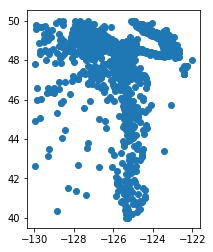

In [43]:
np.gradient(np.gradient(temps.iloc[0]))

# Read Kelp Locations

In [6]:
kelp_forest = xr.open_dataset("../data/kelp_biomass/LandsatKelpBiomass_2017.nc").to_dataframe() #biomass in kg
print("Kelp Forest Coordinate Bounds: \n [({},{}), ({},{})]"\
      .format(min(kelp_forest.lat), min(kelp_forest.lon), max(kelp_forest.lat), max(kelp_forest.lon)))
areas_with_kelp = kelp_forest[(kelp_forest.year == 2015) & (kelp_forest.quarter == 4) & (kelp_forest.biomass > 0)]
geom = areas_with_kelp.apply(lambda x : Point([x['lat'],x['lon']]), axis=1)
kelper = gpd.GeoDataFrame(areas_with_kelp, crs = {'init' :'epsg:4326'}, geometry=geom) #geom is a Series
kelper = kelper.reset_index()
kelper = kelper.iloc[:, [2, 3, 6, 12]]
kelper.to_pickle('../data/pickles/kelp_biomass.pkl')
kelper.head()

Kelp Forest Coordinate Bounds: 
 [(32.35732391,-122.3298817), (37.11449796,-117.1293993)]


lat         lon  biomass                          geometry
0  32.519277 -117.142836    265.0  POINT (32.51927713 -117.1428356)
1  32.519547 -117.143155    635.0   POINT (32.5195474 -117.1431554)
2  32.519548 -117.142836    275.0   POINT (32.51954776 -117.142836)
3  32.519548 -117.142197    272.0  POINT (32.51954849 -117.1421972)
4  32.519818 -117.143156    565.0  POINT (32.51981803 -117.1431559)

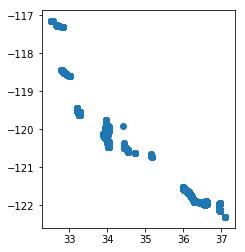

In [5]:
kelper.plot()

In [3]:
a = gpd.read_file('../../data/MAN_CA_KelpAdmin/MAN_CA_KelpAdmin.shp')

In [4]:
a.head()

KelpBed Exclusions    Status     Shape_Leng                  Lessee  \
0        1       None      OPEN   47791.266131                    None   
1        2       None      OPEN  162157.655298                    None   
2        3       None    LEASED   35916.074628  KNOCEAN Sciences, Inc.   
3        4       None  LEASABLE  101285.862462                    None   
4        5       None  LEASABLE   41830.085472                    None   

     TermEnds     Shape_Le_1    Shape_Area  \
0        None   47791.266131  4.429537e+07   
1        None  162157.655298  1.413336e+08   
2  2017-04-11   35916.074628  6.300310e+07   
3        None  101285.862462  9.546491e+07   
4        None   41830.085472  6.637086e+07   

                                            geometry  
0  POLYGON ((269959.375 -601949.5, 269971.8438000...  
1  POLYGON ((262135.2813000008 -582135, 262134.93...  
2  POLYGON ((251498.261500001 -580250.8181999996,...  
3  POLYGON ((256441.9941999987 -570015.5066999998...  
4  POLYGON ((249535.8663999997 -556316.0986000001...

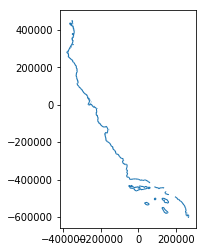

In [5]:
a.plot()

In [10]:
a.shape

(87, 9)

In [16]:
b = gpd.read_file('../../data/MAN_CA_CRFS_microblocks2013/MAN_CA_CRFS_microblocks2013.shp')

In [17]:
b.head()

BLOCK10_ID  NM_ID2 NM_INDEX  BLK_CODE  CNTRY_CODE  ISLD_CODE           X  \
0         501      30   501-30         1          59          0 -122.324999   
1         501      31   501-31         1          59          0 -122.308333   
2         501      32   501-32         1          59          0 -122.291666   
3         501      40   501-40         1          59          0 -122.324999   
4         501      41   501-41         1          59          0 -122.308333   

           Y   Shape_Leng    Shape_Area  \
0  37.108334  6663.370413  2.740165e+06   
1  37.108334  6663.361015  2.740158e+06   
2  37.108334  6663.371918  2.740167e+06   
3  37.091667  6664.013632  2.740762e+06   
4  37.091667  6664.014279  2.740762e+06   

                                            geometry  
0  POLYGON ((-205642.1765000001 -97506.2671000007...  
1  POLYGON ((-204163.6635999996 -97542.3022000007...  
2  POLYGON ((-202685.1403999999 -97578.0669999998...  
3  POLYGON ((-205687.4813999999 -99358.2817000001...  
4  POLYGON ((-204208.6397999991 -99394.3159999996...

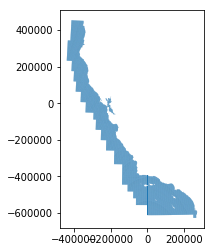

In [18]:
b.plot()

In [19]:
b.shape

(48257, 11)

In [2]:
c = gpd.read_file('../../data/kelp/BIO_CA_Kelp2016/BIO_CA_Kelp2016.shp')

In [3]:
print(c.Class_Name.unique())
c.head()

['Kelp Subsurface' 'Kelp Canopy']


KelpBed       Class_Name    Shape_Leng    Shape_Area  \
0        2  Kelp Subsurface  31221.980123  34254.097061   
1        3  Kelp Subsurface   5217.594632   4952.078393   
2        4  Kelp Subsurface   3496.000000   2708.000000   
3        5  Kelp Subsurface     84.000000     84.000000   
4        6  Kelp Subsurface   2224.000000   1668.000000   

                                            geometry  
0  (POLYGON ((258852 -592688, 258854 -592688, 258...  
1  (POLYGON ((258336 -590546, 258336 -590550, 258...  
2  (POLYGON ((256044 -574596, 256046 -574596, 256...  
3  (POLYGON ((257008 -567406, 257008 -567408, 257...  
4  (POLYGON ((251912 -547468, 251910 -547468, 251...

In [4]:
c.iloc[122].geometry

In [23]:
c.shape

(155, 5)

# Read PAR data

In [8]:
par = xr.open_dataset('../../data/par/S20102132010243.L3m_MO_PAR_par_9km.nc')
par

<xarray.Dataset>
Dimensions:  (eightbitcolor: 256, lat: 2160, lon: 4320, rgb: 3)
Coordinates:
  * lat      (lat) float32 89.958336 89.875 89.79167 89.708336 89.625 ...
  * lon      (lon) float32 -179.95833 -179.875 -179.79166 -179.70833 ...
Dimensions without coordinates: eightbitcolor, rgb
Data variables:
    par      (lat, lon) float32 ...
    palette  (rgb, eightbitcolor) uint8 ...
Attributes:
    product_name:                      S20102132010243.L3m_MO_PAR_par_9km.nc
    instrument:                        SeaWiFS
    title:                             SeaWiFS Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Orbview-2
    temporal_range:                    month
    processing_version:                2018.0
    date_created:                      2018-01-31T05:02:32.000Z
    history:                           l3mapgen par=S20102132010243.L3m_MO_PA...
    l2_flag_names:               